In [1]:
import sympy

from einsteinpy.symbolic import MetricTensor, GenericSpacetime
from einsteinpy.symbolic.tensor import tensor_product


sympy.init_printing()

### Metric

In [2]:
## Approximate axisymmetric spacetime 
t, r, phi, z = [sympy.Symbol('t', real=True), sympy.Symbol('r', real=True, positive=True), 
                sympy.Symbol('\\phi', real=True), sympy.Symbol('z', real=True)]

Phi = sympy.Function("\\Phi", real=True)(r, z)

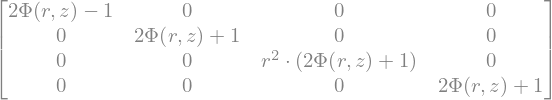

In [3]:
g = sympy.diag( -(1 - 2*Phi), (1 + 2*Phi), (1 + 2*Phi)*r**2 , (1 + 2*Phi))

g = MetricTensor(g.tolist(), [t, r, phi, z])
g.tensor()

In [4]:
def discardTerm(t, order=1.5):
    """
    This function does power counting of Phi and discards the term if the order is above the limit
    
    Paramters
    -------
        t : sympy.core.mul.Mul
            The term
        order : float
            The minimum order to discard
        
    Returns
    -------
        Boolean
            Whether the order of the term is >= the minimum order
    """
    n_o_Phi = t.count(Phi)

    for a in t.atoms(sympy.Pow):
        #print("---", a, a.as_base_exp(), a.as_base_exp()[0])
        if len(a.as_base_exp()[0].atoms(Phi)):
            n_o_Phi += a.as_base_exp()[1] -1
    
    n_o_p = n_o_Phi
    discard = n_o_p >= order
    #print(f"{t}  {n_o_Phi} Phis  -> {discard}")
    return discard
    

def removeHigherOrders(expr, order=1.5):
    """
    This function goes through each term of an expression and checks whether to keep the terms. 
    Returns the cleansed expression
    
    Parameters
    ----------
        expr : ~sympy.core.expr.Expr
            The expression
        order : float
            Minimum order to remove
        
    Returns
    -------
        ~sympy.core.expr.Expr
            The cleansed expression
    """
    expr = sympy.expand(expr)
    if isinstance(expr, sympy.core.relational.Equality):
        return sympy.Eq(removeHigherOrders(expr.lhs, order=order), removeHigherOrders(expr.rhs, order=order))
    elif isinstance(expr, sympy.core.add.Add):
        new_expr = 0
        for t in expr.args:
            if not discardTerm(t,order=order):
                new_expr += t
        return new_expr
    elif isinstance(expr, sympy.core.mul.Mul):
        return 0 if discardTerm(expr, order=order) else expr
    elif isinstance(expr, sympy.core.numbers.Zero):
        return expr
    else:
        print(f"Cannot simplify expression of type {type(expr)}")
        return expr


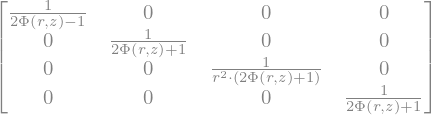

In [5]:
# We have to approximate the inverse metric to correctly raise and lower indices
g._invmetric = None
g.inv().tensor()

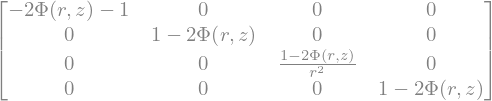

In [6]:
# Taylor expand the above terms
ginv = sympy.diag( - (1 + 2*Phi  )  ,
                      (1 - 2*Phi), (1 - 2*Phi )/r**2, (1 - 2*Phi))

g._invmetric.arr = sympy.Array(ginv.tolist())
g.inv().tensor()

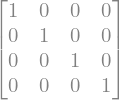

In [7]:
# Check if we got the right approximation
delta = tensor_product(g, g.inv(), 1, 0)
delta.simplify(discard_terms=removeHigherOrders)

In [8]:
# Create Spacetime object to facilitate computations
st = GenericSpacetime(g)

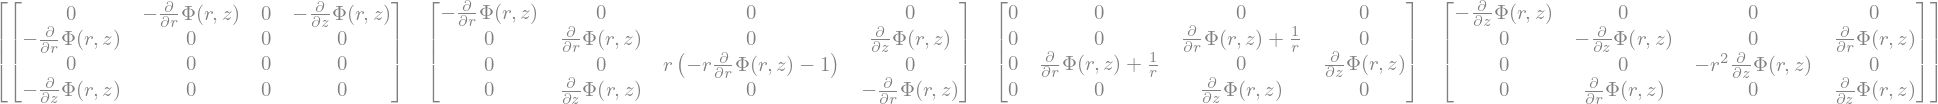

In [9]:
# We can now just pass our removeHigherOrders function to only keep terms at linear order in our tensors
st.ChristoffelSymbols.simplify(discard_terms=removeHigherOrders)

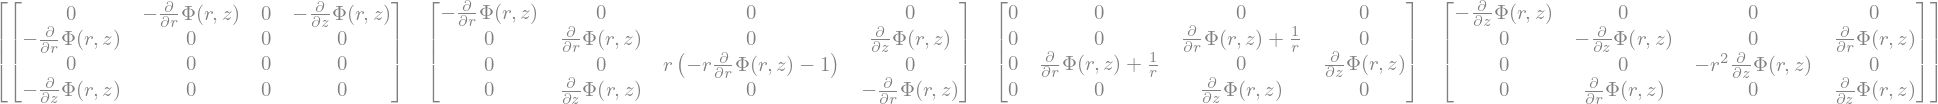

In [10]:
# Careful, this is applied in place
st.ChristoffelSymbols.tensor()

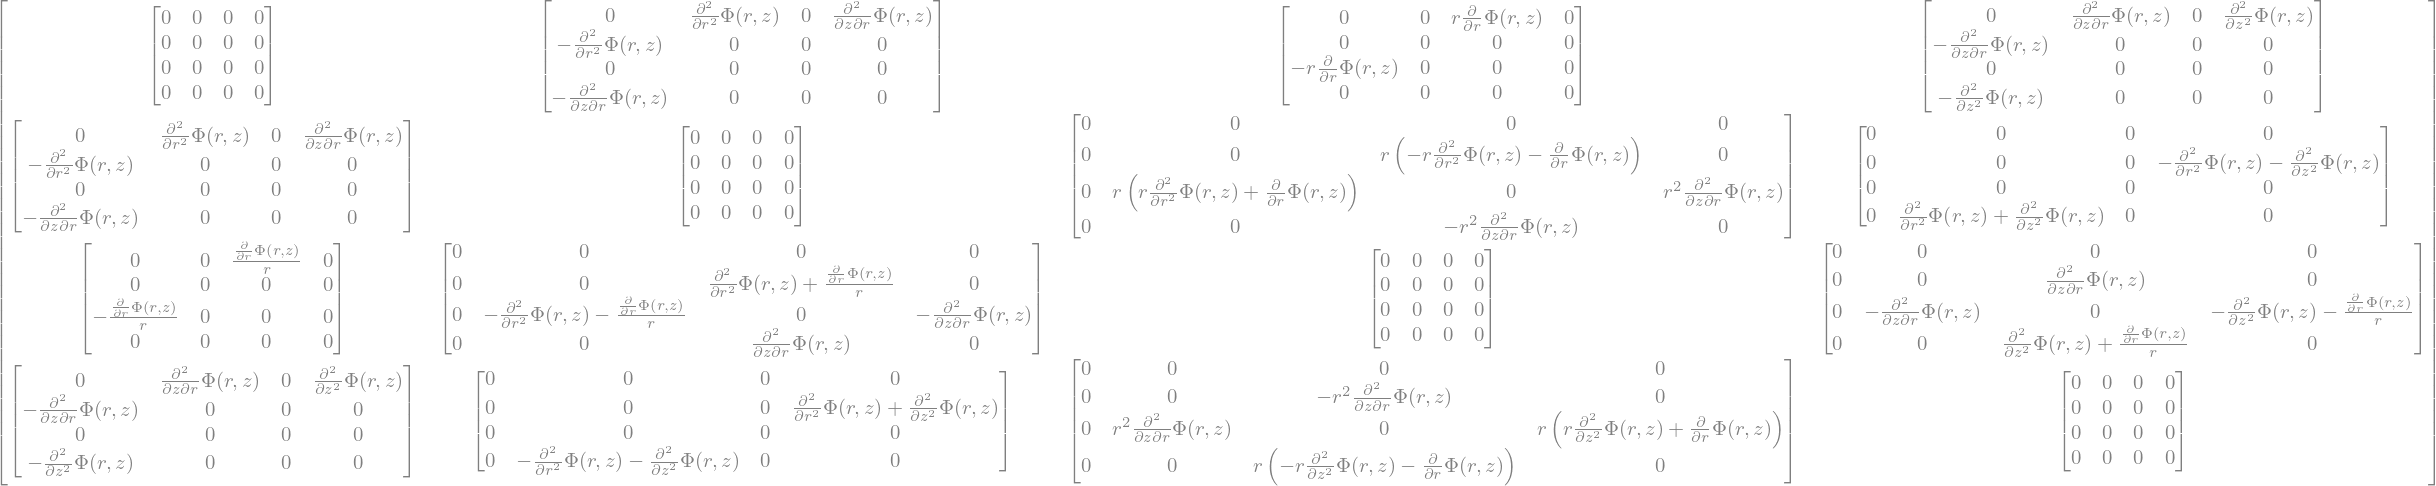

In [11]:
# To facilitate subsequent computations
st.RiemannTensor.simplify(discard_terms=removeHigherOrders)

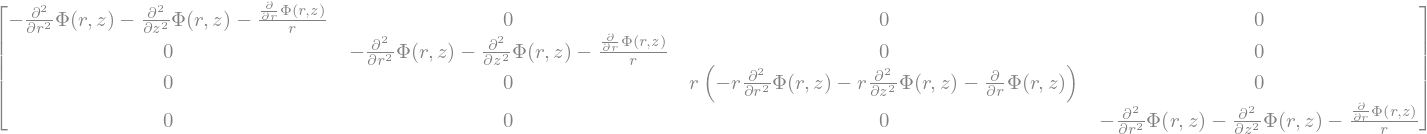

In [12]:
st.RicciTensor.simplify(discard_terms=removeHigherOrders)

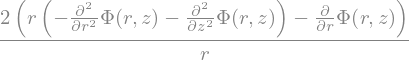

In [13]:
st.RicciScalar.simplify(discard_terms=removeHigherOrders)